## Limpieza de datos

Procedamos a la  limpieza de los datos de origen, tanto los de entrenamiento como de test. La fuente de la que se extraen los datos se puede consultar en [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
input_path = '/content/drive/MyDrive/Colab_Notebooks/APBD/Evaluacion/data/{}'
output_path= '/content/drive/MyDrive/Colab_Notebooks/APBD/Evaluacion/data/output/{}'

Cargamos las librerías necesarias y funciones auxiliares que usaremos a lo largo del notebook.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

def count_missings_aux(c):
    return F.sum(F.col(c).isNull().cast(IntegerType())).alias(c)

def count_missings(df):
    exprs = [count_missings_aux(c) for c in df.columns]
    df.agg(*exprs).show()

def compare_schemas(df1, df2):
    df1_dict = dict(df1.dtypes)
    df2_dict = dict(df2.dtypes)
    discrepancias = []
    for column in df1_dict:
        if column in df2_dict:
            if df1_dict[column] != df2_dict[column]:
                discrepancias.append((column, df1_dict[column], df2_dict[column]))
        else:
            discrepancias.append((column, df1_dict[column], 'Column missing in test_df'))

    for column in df2_dict:
        if column not in df1_dict:
            discrepancias.append((column, 'Column missing in train_df', df2_dict[column]))

    if discrepancias:
        print("Discrepancies found:")
        for discrepancia in discrepancias:
            print(f"Column: {discrepancia[0]}, Train Schema: {discrepancia[1]}, Test Schema: {discrepancia[2]}")
    else:
        print("No discrepancies found. The schemas are consistent.")
    return discrepancias

def extract_columns_by_type(df, data_type):
  columns_of_type = [col for col, dtype in df.dtypes if dtype == data_type]
  return df.select(columns_of_type)

def extrae_cadenas_NA(df, var):
  print(f"El numero de resgistros con valores nulos en la variable {var} es: {df.filter(df[var] == 'NA').count()}")

def impute_and_convert(df,vars,impute,dtype):
  for var, imp_value in zip(vars, impute):
        df = df.withColumn(
            var,
            F.when(F.col(var) == 'NA', imp_value).otherwise(F.col(var))
        ).withColumn(
            var, F.col(var).cast(dtype)
        )
  return df

def plot_freqs(categories, values, max_y):
    %matplotlib inline
    plt.bar(range(len(categories)), values, align='center')
    plt.xticks(range(len(categories)), categories)
    plt.ylim([0, max_y])

Inicializamos la conexión con el motor de ejecución de Spark y cargamos los datasets.

Cabe destacar que en la documentación de la descripción de las variables podemos observar ciertas de ellas que son categóricas y contienen un nivel con valor NA, haciendo referencia a que no puede optar a ninguna de los demás niveles. Por ejemplo, si una vivienda no tiene garaje, el valor de todas las variables de tipo categórico que describen las características de ese garaje, como `GarageType`, tomarán el valor NA. Esto es algo muy a tener en cuenta porque no son valores faltantes y los verdaderos valores faltantes también están codificados con la misma cadena.

Por tanto, en un principio no indicaremos explícitamente cómo se codifican los valores nulos.

In [4]:
spark = SparkSession.builder.master("local[*]").appName("nb03.1") \
    .getOrCreate()

In [5]:
train_df = spark.read.csv(path = input_path.format('train.csv'), header = True, inferSchema = True)
test_df = spark.read.csv(path = input_path.format('test.csv'), header = True, inferSchema = True)
print(f"El conjunto de entrenamiento cuenta con {train_df.count()} registros")
print(f"El conjunto de test cuenta con {test_df.count()} registros")
print(f"El numero de variables del conjunto de entrenamiento es {len(train_df.columns)}")
print(f"El numero de variables del conjunto de test es {len(test_df.columns)}")

El conjunto de entrenamiento cuenta con 1460 registros
El conjunto de test cuenta con 1459 registros
El numero de variables del conjunto de entrenamiento es 81
El numero de variables del conjunto de test es 80


Observamos como tenemos prácticamente el mismo número de registros en ambos datasets. En el conjunto de test contamos con una variable menos, correspondiente a la variable objetivo

In [6]:
train_df.show(3)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

En primer lugar vamos a analizar la variable objetivo `SalePrice`. Posteriormente, crearemos el dataset con la totalidad de los datos eliminando previamente la variable objetivo de `train_df`.

In [7]:
count_missings(train_df.select('SalePrice'))

+---------+
|SalePrice|
+---------+
|        0|
+---------+



In [8]:
print(train_df.dtypes[-1])
train_df.select('SalePrice').sort(F.desc('SalePrice')).show(3)
train_df.select('SalePrice').sort(F.asc('SalePrice')).show(3)

('SalePrice', 'int')
+---------+
|SalePrice|
+---------+
|   755000|
|   745000|
|   625000|
+---------+
only showing top 3 rows

+---------+
|SalePrice|
+---------+
|    34900|
|    35311|
|    37900|
+---------+
only showing top 3 rows



La variable objetivo tiene los datos limpios. Procedemos a unir ambos datasets. Antes, comprobamos que los esquemas coinciden.

In [9]:
train_df_nosp = train_df.drop('SalePrice')
discrepancias = compare_schemas(train_df_nosp, test_df)

Discrepancies found:
Column: BsmtFinSF1, Train Schema: int, Test Schema: string
Column: BsmtFinSF2, Train Schema: int, Test Schema: string
Column: BsmtUnfSF, Train Schema: int, Test Schema: string
Column: TotalBsmtSF, Train Schema: int, Test Schema: string
Column: BsmtFullBath, Train Schema: int, Test Schema: string
Column: BsmtHalfBath, Train Schema: int, Test Schema: string
Column: GarageCars, Train Schema: int, Test Schema: string
Column: GarageArea, Train Schema: int, Test Schema: string


In [10]:
train_df_nosp.select(discrepancias[0][0]).sort(F.desc(discrepancias[0][0])).show(3)
test_df.select(discrepancias[0][0]).sort(F.desc(discrepancias[0][0])).show(3)

+----------+
|BsmtFinSF1|
+----------+
|      5644|
|      2260|
|      2188|
+----------+
only showing top 3 rows

+----------+
|BsmtFinSF1|
+----------+
|        NA|
|       998|
|       996|
+----------+
only showing top 3 rows



El motivo de que se haya parseado como string en test_df es por la presencia de la cadena NA, que no hemos indicado al comienzo que se tome como valor nulo.

En lo que nos trasciende en este momento, vamos a tomar el tipo de dato más general para que pueda parsear correctamente la cadena 'NA', es decir, `String`. Tomaremos por tanto el esquema de test_df para el dataset completo.

In [11]:
train_df_nosp = train_df_nosp.select(test_df.columns)
full_df = train_df_nosp.union(test_df)

In [12]:
full_df.show(3)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType

Veamos los distintos tipos de dato que tenemos en el dataset para tratarlos de forma distinta.

In [13]:
list(set([dtype[1] for dtype in full_df.dtypes]))

['string', 'int']

### Variables parseadas como numéricas

In [14]:
full_df_integer = extract_columns_by_type(full_df,'int')
full_df_integer.show(3)

+---+----------+-------+-----------+-----------+---------+------------+--------+--------+------------+---------+--------+--------+------------+------------+------------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+
| Id|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|
+---+----------+-------+-----------+-----------+---------+------------+--------+--------+------------+---------+--------+--------+------------+------------+------------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+
|  1|        60|   8450|          7|          5|     2003|        2003|     856|     854|           0|     1710|       2|       1|           3|           1|           8|         0|       

In [15]:
count_missings(full_df_integer)

+---+----------+-------+-----------+-----------+---------+------------+--------+--------+------------+---------+--------+--------+------------+------------+------------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+
| Id|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|
+---+----------+-------+-----------+-----------+---------+------------+--------+--------+------------+---------+--------+--------+------------+------------+------------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+
|  0|         0|      0|          0|          0|        0|           0|       0|       0|           0|        0|       0|       0|           0|           0|           0|         0|       

Lógicamente, debido a que previamente han sido parseadas como `String` las variables numéricas que contenían nulos, no contamos con valores faltantes en las restantes.



### Variables numéricas parseadas como `String`

Tratemos en primer lugar esas variables con discrepancias en el esquema de los conjuntos de entrenamiento y test, y que realmente son de tipo numérico.

In [17]:
vars = [discrepancia[0] for discrepancia in discrepancias]
vars

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea']

Veamos las relativas a los sótanos.

In [18]:
full_df.select(vars[:-2] + ['BsmtFinType1'] ).orderBy(F.desc(vars[0])).show(3)

+----------+----------+---------+-----------+------------+------------+------------+
|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|BsmtFullBath|BsmtHalfBath|BsmtFinType1|
+----------+----------+---------+-----------+------------+------------+------------+
|        NA|        NA|       NA|         NA|          NA|          NA|          NA|
|       998|         0|      177|       1175|           1|           0|         GLQ|
|       998|         0|      294|       1292|           1|           0|         LwQ|
+----------+----------+---------+-----------+------------+------------+------------+
only showing top 3 rows



In [19]:
full_df.filter(F.col('BsmtFinType1') == 'NA').select(vars[:-2] + ['BsmtFinType1']).show(3)

+----------+----------+---------+-----------+------------+------------+------------+
|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|BsmtFullBath|BsmtHalfBath|BsmtFinType1|
+----------+----------+---------+-----------+------------+------------+------------+
|         0|         0|        0|          0|           0|           0|          NA|
|         0|         0|        0|          0|           0|           0|          NA|
|         0|         0|        0|          0|           0|           0|          NA|
+----------+----------+---------+-----------+------------+------------+------------+
only showing top 3 rows



La variable `BsmtFinType1` nos indica que la vivienda no cuenta con sótano, y es por ello que todas las variables referentes al sótano para esta vivienda están vacías. Imputaremos estos valores por 0.

Veamos ahora las variables relativas a los garajes

In [20]:
garage_vars = ['GarageCars', 'GarageArea', 'GarageType','GarageYrBlt','GarageFinish', 'GarageQual','GarageCond']
full_df.filter(
    (F.col('GarageCars') == 'NA') |
    (F.col('GarageArea') == 'NA')
).select(['Id']+garage_vars).show(3)

+----+----------+----------+----------+-----------+------------+----------+----------+
|  Id|GarageCars|GarageArea|GarageType|GarageYrBlt|GarageFinish|GarageQual|GarageCond|
+----+----------+----------+----------+-----------+------------+----------+----------+
|2577|        NA|        NA|    Detchd|         NA|          NA|        NA|        NA|
+----+----------+----------+----------+-----------+------------+----------+----------+



In [21]:
full_df.filter(full_df.GarageType == 'NA').select(garage_vars).show(3)

+----------+----------+----------+-----------+------------+----------+----------+
|GarageCars|GarageArea|GarageType|GarageYrBlt|GarageFinish|GarageQual|GarageCond|
+----------+----------+----------+-----------+------------+----------+----------+
|         0|         0|        NA|         NA|          NA|        NA|        NA|
|         0|         0|        NA|         NA|          NA|        NA|        NA|
|         0|         0|        NA|         NA|          NA|        NA|        NA|
+----------+----------+----------+-----------+------------+----------+----------+
only showing top 3 rows



Parece haber un error en el dato `GarageType` y realmente esta vivienda no cuenta con garaje. Cambiamos el valor de esta variable e imputaremos a 0 también los valores nulos de `GarageCars` y `GarageArea`.

In [22]:
full_df = full_df.withColumn(
    'GarageType',
    F.when(F.col('Id') == 2577, 'NA').otherwise(F.col('GarageType'))
)

Continuamos ahora con el resto de variables.

In [23]:
full_df_integer = extract_columns_by_type(full_df, 'int')
full_df_string = extract_columns_by_type(full_df,'string')
full_df_string.show(3)

+--------+-----------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+------------+------------+-----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+------+-----+-----------+--------+-------------+
|MSZoning|LotFrontage|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|RoofStyle|RoofMatl|Exterior1st|Exterior2nd|MasVnrType|MasVnrArea|ExterQual|ExterCond|Foundation|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinSF1|BsmtFinType2|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|Heating|HeatingQC|CentralAir|Electrical|BsmtFullBath|BsmtHalfBath|KitchenQual|Funct

Observamos como sigue habiendo variables numéricas que siguen codificadas como `String`.  

Analicemos la variable `LotFrontage`, que hace referencia a la longitud del frente del lote de la propiedad.

In [24]:
extrae_cadenas_NA(full_df,'LotFrontage')
print(f"De esos registros, en {full_df.filter((full_df.LotFrontage == 'NA') & (full_df.Alley == 'NA')).count()} de los casos no tiene acceso por callejon ")

El numero de resgistros con valores nulos en la variable LotFrontage es: 486
De esos registros, en 473 de los casos no tiene acceso por callejon 


La razón de la presencia de estos valores nulos de `LotFrontage` se puede deber al difícil acceso a esa medición por no tener acceso por callejón (`Alley` = NA). Es razonable pensar en una fuerte correlación entre ambas variables, luego imputaremos los valores nulos por la mediana de las viviendas que no tienen acceso por callejón y sí tienen rellena la variable `LotFrontage`.

In [25]:
df = full_df.filter((full_df.LotFrontage != 'NA') & (full_df.Alley == 'NA'))\
      .withColumn('LotFrontage', F.col('LotFrontage').cast('float'))
impute_LotFrontage = df.approxQuantile('LotFrontage', [0.5], 0)[0]

Veamos `MasVnrArea`, que representa la superficie de revestimiento de mampostería en pies cuadrados.

In [26]:
extrae_cadenas_NA(full_df,'MasVnrArea')
print(f"De esos registros, en {full_df.filter((full_df.MasVnrArea == 'NA') & (full_df.MasVnrType == 'NA')).count()} de los casos no tienen revestimiento de mampostería ")

El numero de resgistros con valores nulos en la variable MasVnrArea es: 23
De esos registros, en 23 de los casos no tienen revestimiento de mampostería 


Es claro por tanto que debemos imputar los valores nulos por 0.

In [27]:
impute_MasVnrArea = 0

Veamos `GarageYrBlt`, que representa el año de construcción del garaje.

In [28]:
extrae_cadenas_NA(full_df,'GarageYrBlt')

El numero de resgistros con valores nulos en la variable GarageYrBlt es: 159


Los valores nulos se corresponden con viviendas que no tienen garaje, luego no es razonable imputar los valores nulos. De todos modos, es una variable que no va a ser muy significativa para los modelos de aprendizaje automático y como podemos ver a continuación está altamente correlada con `YearBuilt`, que describe el año de construcción de la vivienda.

In [29]:
df = full_df.filter(full_df.GarageYrBlt != 'NA').withColumn('GarageYrBlt', F.col('GarageYrBlt').cast('int'))
df.stat.corr('YearBuilt', 'GarageYrBlt')

0.8348123731631019

Por estos motivos optaremos por eliminar esta variable del dataframe.

Procedemos a imputar los valores nulos vistos anteriormente.   

In [30]:
impute = [0]*len(vars)
vars.append('LotFrontage')
vars.append('MasVnrArea')
impute.append(impute_LotFrontage)
impute.append(impute_MasVnrArea)

In [33]:
full_df = impute_and_convert(full_df,vars,impute, 'int')

### Variables categóricas

Atendiendo a la documentación y teniendo en cuenta lo comentado en el principio del documento, podemos obtener las variables que tienen categorías NA. Vamos a codificarlas con el valor NP (no procede), para no confundirlos con los posibles valores nulos. Destacamos además que el enfoque es distinto para `MasVnrType`, pues en este caso los valores None hacen referencia a que no tiene revestimiento de mampostería, mientras que NA denota un valor faltante.

In [34]:
vars_withNA = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
               'BsmtFinType2','FireplaceQu','GarageType','GarageFinish',
               'GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

full_df = full_df.select([
    F.when(F.col(c) == 'NA', 'NP').otherwise(F.col(c)).alias(c) if c in vars_withNA else F.col(c)
    for c in full_df.columns
])

full_df = full_df.select([
    F.when(F.col(c) == 'None', 'NP').otherwise(F.col(c)).alias(c) if c == 'MasVnrType' else F.col(c)
    for c in full_df.columns
])

full_df = full_df.select([
    F.when(F.col(c) == "NA", None).otherwise(F.col(c)).alias(c)
    for c in full_df.columns
])

full_df = full_df.drop('GarageYrBlt')

Veamos los verdaderos valores nulos restantes.

In [35]:
full_df_integer = extract_columns_by_type(full_df,'int')
full_df_string = extract_columns_by_type(full_df,'string')

In [ ]:
count_missings(full_df_integer)

+---+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+
| Id|MSSubClass|LotFrontage|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MasVnrArea|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|
+---+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+-----

In [36]:
count_missings(full_df_string)

+--------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+------------+-------+---------+----------+----------+-----------+----------+-----------+----------+------------+----------+----------+----------+------+-----+-----------+--------+-------------+
|MSZoning|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|RoofStyle|RoofMatl|Exterior1st|Exterior2nd|MasVnrType|ExterQual|ExterCond|Foundation|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|Heating|HeatingQC|CentralAir|Electrical|KitchenQual|Functional|FireplaceQu|GarageType|GarageFinish|GarageQual|GarageCond|PavedDrive|PoolQC|Fence|MiscFeature|SaleType|SaleCondition|
+--------+------+-----+--------+-----------+---------+---------+---------+------------+---------

Variable `MSZoning`.

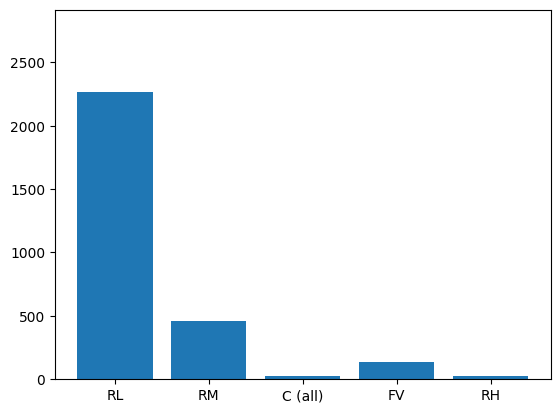

In [37]:
df = full_df.filter(F.col('MSZoning').isNotNull())
freq_table = df.select('MSZoning').rdd.map(lambda row: row.MSZoning).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

Veamos la media de la variable `LotArea` para los distintos niveles de `MSZoning` en los valores no nulos.

In [38]:
df = full_df.filter(F.col('MSZoning').isNotNull())
df.groupBy('MSZoning').avg('LotArea').show()

+--------+------------------+
|MSZoning|      avg(LotArea)|
+--------+------------------+
| C (all)|           8320.72|
|      RH| 7506.461538461538|
|      FV| 6549.359712230216|
|      RL|11169.471964679911|
|      RM| 6400.239130434783|
+--------+------------------+



In [39]:
full_df.filter(F.col('MSZoning').isNull()).select('LotArea').show()

+-------+
|LotArea|
+-------+
|  21780|
|  14584|
|  56600|
|  31250|
+-------+



Es razonable por tanto imputar por RM o FV. Analicemos ahora por la variable `YearRemodAdd`.

In [40]:
df = full_df.filter(F.col('MSZoning').isNotNull())
df.groupBy('MSZoning').avg('YearRemodAdd').show()
full_df.filter(F.col('MSZoning').isNull()).select('YearRemodAdd').show()

+--------+------------------+
|MSZoning| avg(YearRemodAdd)|
+--------+------------------+
| C (all)|           1961.04|
|      RH|1972.2692307692307|
|      FV| 2004.431654676259|
|      RL|1985.3086092715232|
|      RM|1975.2608695652175|
+--------+------------------+

+------------+
|YearRemodAdd|
+------------+
|        1950|
|        1952|
|        1950|
|        1951|
+------------+



Imputaremos por tanto los valores nulos por el valor 'RM'.

Variable `Utilities`.

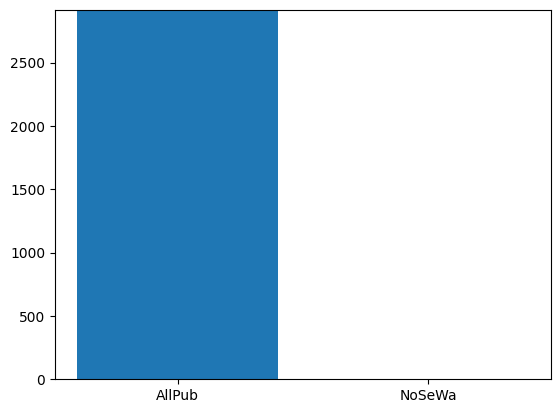

In [41]:
df = full_df.filter(F.col('Utilities').isNotNull())
freq_table = df.select('Utilities').rdd.map(lambda row: row.Utilities).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

Imputaremos por 'AllPub'.

Variable `Exterior1st` y `Exterior2nd`.

In [42]:
full_df.filter(full_df.Exterior1st.isNull()).select('Exterior1st', 'Exterior2nd', 'Neighborhood').show()

+-----------+-----------+------------+
|Exterior1st|Exterior2nd|Neighborhood|
+-----------+-----------+------------+
|       NULL|       NULL|     Edwards|
+-----------+-----------+------------+



Observamos como los valores nulos se corresponden a la misma observación.

In [43]:
coincidencias = full_df.filter(F.col("Exterior1st") == F.col("Exterior2nd")).count()
print(f"Las variables Exterior1st y Exterior2nd coinciden en {coincidencias} casos de {full_df.count()}")

Las variables Exterior1st y Exterior2nd coinciden en 2481 casos de 2919


Vamos a imputar el mismo valor a ambas variables. Imputaremos por la moda del material para el barrio en el que se encuentra la vivienda.

In [44]:
df = full_df.filter((F.col('Exterior1st').isNotNull()) & (F.col('Neighborhood') == 'Edwards'))
freq_table = df.select('Exterior1st').rdd.map(lambda row: row.Exterior1st).countByValue()
dict(sorted(freq_table.items(), key=lambda item: item[1], reverse = True))

{'Wd Sdng': 45,
 'VinylSd': 38,
 'MetalSd': 37,
 'HdBoard': 21,
 'Plywood': 16,
 'WdShing': 13,
 'AsbShng': 7,
 'Stucco': 6,
 'BrkFace': 4,
 'CemntBd': 3,
 'BrkComm': 2,
 'AsphShn': 1}

Lo haremos por 'Wd Sdng'.

Variable `MasVnrType`.

Recordemos que en 23 de los 24 casos que tenemos valor nulo imputamos el area a 0. Tenemos otro registro que sí tiene valor en `MasVnrArea`.

In [45]:
full_df.filter((full_df.MasVnrType.isNull()) & (full_df.MasVnrArea > 0)).select('Id','MasVnrType','MasVnrArea').show(5)

+----+----------+----------+
|  Id|MasVnrType|MasVnrArea|
+----+----------+----------+
|2611|      NULL|       198|
+----+----------+----------+



In [46]:
full_df = full_df.withColumn(
    "MasVnrType",
    F.when((F.col("MasVnrType").isNull()) & (F.col("Id") != 2611), "NP")
    .otherwise(F.col("MasVnrType"))
)

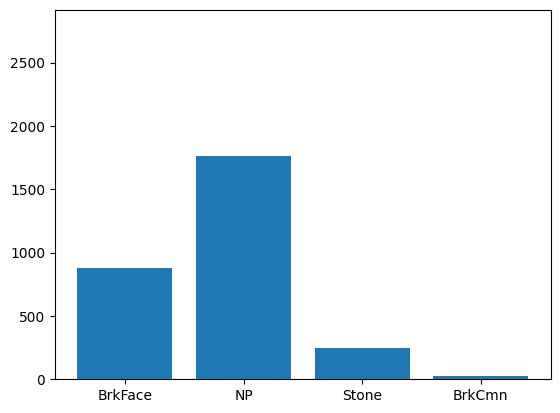

In [48]:
df = full_df.filter((F.col('MasVnrType').isNotNull()))
freq_table = df.select('MasVnrType').rdd.map(lambda row: row.MasVnrType).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

In [49]:
df_notnull = full_df.filter(full_df.MasVnrType.isNotNull())
df_notnull.groupBy('MasVnrType').avg('MasVnrArea').show()

+----------+------------------+
|MasVnrType|   avg(MasVnrArea)|
+----------+------------------+
|    BrkCmn|            195.48|
|        NP|0.6980169971671388|
|     Stone|239.55020080321285|
|   BrkFace|261.67235494880543|
+----------+------------------+



Imputaremos por 'BrkCmn'.

Variable `Electrical`.

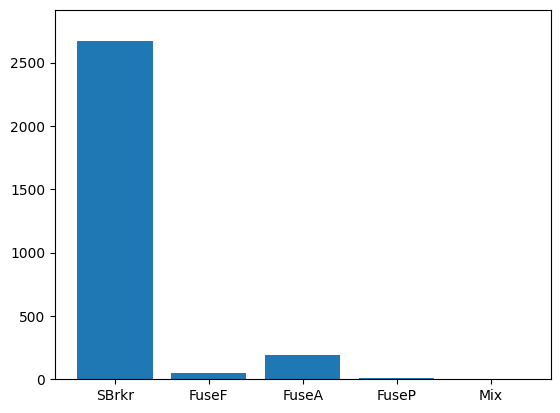

In [50]:
df = full_df.filter((F.col('Electrical').isNotNull()))
freq_table = df.select('Electrical').rdd.map(lambda row: row.Electrical).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

In [51]:
full_df.filter(full_df.Electrical.isNull()).select('Electrical','Utilities').show()

+----------+---------+
|Electrical|Utilities|
+----------+---------+
|      NULL|   AllPub|
+----------+---------+



Puesto que la gran mayoría de las viviendas cuenta con el sistema eléctrico 'SBrkr' y la variable que mejor puede explicarla tiene el valor 'AllPub', como prácticamente la totalidad de los registros, imputaremos por 'SBrkr'.

Variable `KitchenQual`.

In [52]:
full_df.filter((F.col('KitchenQual').isNull())).select('KitchenQual','KitchenAbvGr','OverallQual').show()

+-----------+------------+-----------+
|KitchenQual|KitchenAbvGr|OverallQual|
+-----------+------------+-----------+
|       NULL|           1|          5|
+-----------+------------+-----------+



Veamos como se distribuyen los niveles de calidad de la cocina para las viviendas con 1 cocina sobre rasante y valoración general igual a 5.

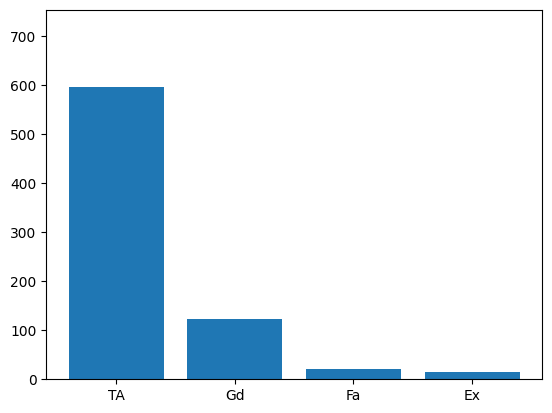

In [53]:
df = full_df.filter(((F.col('KitchenQual').isNotNull())) & (F.col('KitchenAbvGr') == 1) & (F.col('OverallQual') == 5))
freq_table = df.select('KitchenQual').rdd.map(lambda row: row.KitchenQual).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

Imputaremos por 'TA' (Típico/Promedio).

Variable `Functional`.

In [54]:
full_df.filter((F.col('Functional').isNull())).show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyl

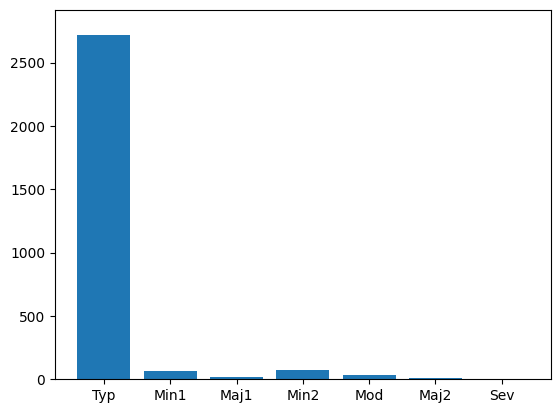

In [55]:
df = full_df.filter(((F.col('Functional').isNotNull())))
freq_table = df.select('Functional').rdd.map(lambda row: row.Functional).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

No conocemos qué variables explican `Fuctional`, y en la documentación se dice que se asuma como 'Typ' en ese caso.

Variable `SaleType`.

In [56]:
full_df.filter((F.col('SaleType').isNull())).show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyl

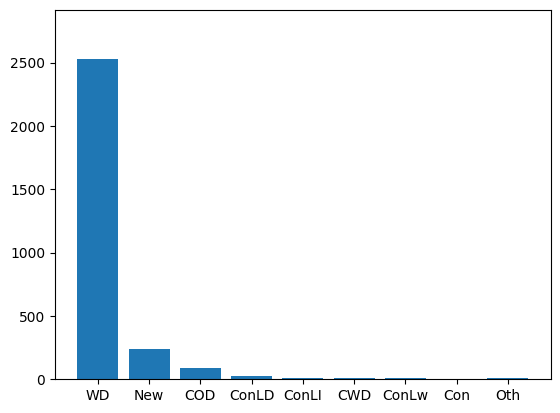

In [57]:
df = full_df.filter(((F.col('SaleType').isNotNull())))
freq_table = df.select('SaleType').rdd.map(lambda row: row.SaleType).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

Imputaremos por 'WD'.

In [58]:
imputaciones = {
    "MSZoning": "RM",
    "Utilities": "AllPub",
    "Exterior1st": "Wd Sdng",
    "Exterior2nd": "Wd Sdng",
    "MasVnrType": "BrkCmm",
    "Electrical": "SBrkr",
    "KitchenQual": "TA",
    "Functional": "Typ",
    "SaleType": "WD"
}

full_df = full_df.fillna(imputaciones)
full_df = full_df.join(train_df.select("Id", "SalePrice"), on="Id", how="left")

Ya tenemos imputados todos los valores nulos. Con esto finalizamos la limpieza de datos.

In [59]:
path = output_path.format('clean_data_csv')
full_df.write.csv(path, header=True, mode='overwrite')

Detenemos el motor Spark.

In [60]:
spark.stop()